### Throat Cancer Classification Model - Hugging Face - Vision Transformer

In [36]:
# !pip install wandb -qqq
# import wandb
# wandb.login()

In [3]:
import wandb

# Set your API key
api_key = "55d0dcd23deb056198b9e5b52abcbdcb0fdbf9bb"

# Log in with the API key
wandb.login(key=api_key)

# Check if the API key is set
api_key = wandb.Settings().api_key
print("Wandb API key:", api_key)


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\s0n0611\.netrc
wandb: Network error (ProxyError), entering retry loop.


Wandb API key: None


In [39]:
import os

# Set WANB mode to "disabled" before importing wandb
os.environ["WANDB_MODE"] = "disabled"
import wandb

# Now, you can check the WANB mode
mode = wandb.Settings().mode
print("Wandb mode:", mode)

Wandb mode: online


In [5]:

import pandas as pd
import torch
from torch.utils.data import Dataset
import os
from torchvision.io import read_image
import matplotlib.pyplot as plt
from PIL import Image
import random
from torchvision.transforms import v2
from tqdm.notebook import tqdm
from pathlib import Path
from datasets import load_dataset
from huggingface_hub import notebook_login
from tqdm.notebook import tqdm
import wandb

# Loading Dataset

In [8]:
from datasets import load_dataset
# create dataset
cancer_classification_dataset = load_dataset("imagefolder", data_dir = "CancerClassification")

Resolving data files:   0%|          | 0/1053 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/462 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/650 [00:00<?, ?it/s]

In [9]:
cancer_classification_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1053
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 462
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 650
    })
})

In [10]:
# Access the first record of the train dataset
first_record_train = cancer_classification_dataset['train'][0]

# Access the first record of the validation dataset
first_record_validation = cancer_classification_dataset['validation'][0]

# Access the first record of the test dataset
first_record_test = cancer_classification_dataset['test'][0]

print("First record of the train dataset:", first_record_train)
print("First record of the validation dataset:", first_record_validation)
print("First record of the test dataset:", first_record_test)


First record of the train dataset: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2862x1348 at 0x1B1C06F58B0>, 'label': 0}
First record of the validation dataset: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2857x1348 at 0x1B1C06F55E0>, 'label': 0}
First record of the test dataset: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2857x1348 at 0x1B1C1D9DFA0>, 'label': 0}


In [11]:
# Assuming label_id is the label ID of the ImageDataset with label 0
label_id = 0

# Retrieve the corresponding label name from the label ID
label_name = id2label[str(label_id)]

print("Label name for label 0:", label_name)


NameError: name 'id2label' is not defined

In [12]:
import numpy as np

# Extract labels from datasets
train_labels = cancer_classification_dataset['train']['label']
validation_labels = cancer_classification_dataset['validation']['label']
test_labels = cancer_classification_dataset['test']['label']

# Find unique class labels
unique_labels = np.unique(np.concatenate([train_labels, validation_labels, test_labels]))

# Print the unique class labels
print("Number of unique class labels:", len(unique_labels))
print("Unique class labels:", unique_labels)


Number of unique class labels: 2
Unique class labels: [0 1]


In [13]:
# Extract labels from datasets
train_labels = cancer_classification_dataset['train']['label']
validation_labels = cancer_classification_dataset['validation']['label']
test_labels = cancer_classification_dataset['test']['label']

## EDA

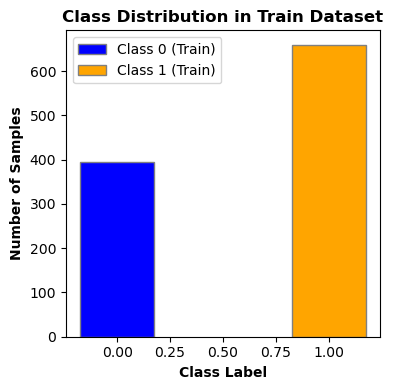

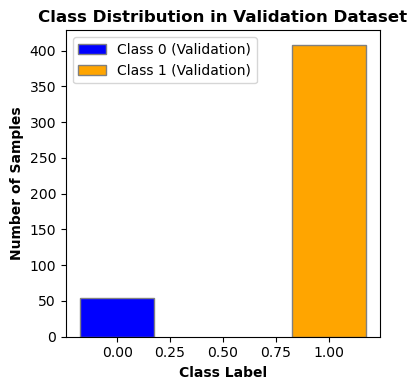

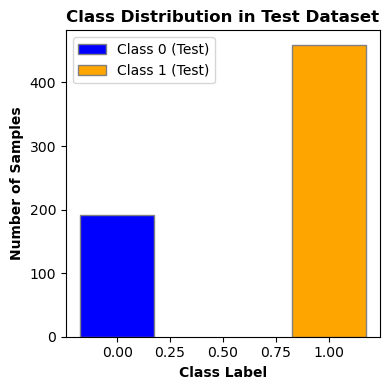

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Extract labels from datasets
train_labels = cancer_classification_dataset['train']['label']
validation_labels = cancer_classification_dataset['validation']['label']
test_labels = cancer_classification_dataset['test']['label']

# Find unique class labels
unique_labels_train = np.unique(train_labels)
unique_labels_validation = np.unique(validation_labels)
unique_labels_test = np.unique(test_labels)

# Calculate class distribution
train_class_distribution = np.array([np.sum(train_labels == label) for label in unique_labels_train])
validation_class_distribution = np.array([np.sum(validation_labels == label) for label in unique_labels_validation])
test_class_distribution = np.array([np.sum(test_labels == label) for label in unique_labels_test])

# Define colors for label classes 0 and 1
color_map = {0: 'blue', 1: 'orange'}

# Set the width of the bars
bar_width = 0.35

# Plot class distribution for train dataset
plt.figure(figsize=(4, 4))
for label, count in zip(unique_labels_train, train_class_distribution):
    plt.bar(label, count, color=color_map[label], width=bar_width, edgecolor='grey', label=f'Class {label} (Train)')
plt.xlabel('Class Label', fontweight='bold')
plt.ylabel('Number of Samples', fontweight='bold')
plt.title('Class Distribution in Train Dataset', fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

# Plot class distribution for validation dataset
plt.figure(figsize=(4, 4))
for label, count in zip(unique_labels_validation, validation_class_distribution):
    plt.bar(label, count, color=color_map[label], width=bar_width, edgecolor='grey', label=f'Class {label} (Validation)')
plt.xlabel('Class Label', fontweight='bold')
plt.ylabel('Number of Samples', fontweight='bold')
plt.title('Class Distribution in Validation Dataset', fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

# Plot class distribution for test dataset
plt.figure(figsize=(4, 4))
for label, count in zip(unique_labels_test, test_class_distribution):
    plt.bar(label, count, color=color_map[label], width=bar_width, edgecolor='grey', label=f'Class {label} (Test)')
plt.xlabel('Class Label', fontweight='bold')
plt.ylabel('Number of Samples', fontweight='bold')
plt.title('Class Distribution in Test Dataset', fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
labels = cancer_classification_dataset["train"].features["label"].names
labels

['Malignant', 'Normal']

## Encoding Labels

In [16]:
labels = cancer_classification_dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [17]:
id2label

{'0': 'Malignant', '1': 'Normal'}

In [18]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

c:\Users\s0n0611\AppData\Local\anaconda3\envs\data_science_base_env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Transform Dataset:
1. Normalize
2. Adjust image so as to make it ready for ViT

In [19]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [20]:
# from torchvision.transforms import RandomAffine, Resize, ToTensor, Normalize

# # Define augmentation and normalization
# # Adjust parameters based on your dataset and model requirements
# transforms = Compose([
#     RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
#     Resize(size),  # Resize to a consistent size
#     ToTensor(),     # Convert PIL Image to Tensor
#     Normalize(mean=[0.5], std=[0.5])  # Normalize pixel values
# ])


In [21]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [22]:
cancer_classification_dataset = cancer_classification_dataset.with_transform(transforms)

In [23]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

# Defining Evaluation Metrics

In [24]:
import evaluate

accuracy = evaluate.load("accuracy")

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')
    mcc = matthews_corrcoef(labels, predictions)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'mcc': mcc
    }


## Model

In [26]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

c:\Users\s0n0611\AppData\Local\anaconda3\envs\data_science_base_env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
import os
from transformers import TrainingArguments, Trainer

# Disable WANB by setting the environment variable
os.environ["WANDB_DISABLED"] = "true"

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="my_awesome_cancer_classification_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_dir='logs',  # Specify logging directory
    logging_steps=10,  # Log metrics every specified number of steps
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=cancer_classification_dataset["train"],
    eval_dataset=cancer_classification_dataset["validation"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


  0%|          | 0/80 [00:00<?, ?it/s]

{'loss': 0.6396, 'grad_norm': 1.1021748781204224, 'learning_rate': 4.8611111111111115e-05, 'epoch': 0.61}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 0.3643978238105774, 'eval_accuracy': 0.8722943722943723, 'eval_precision': 0.8712687874933572, 'eval_recall': 0.8722943722943723, 'eval_f1': 0.8717757722436339, 'eval_mcc': 0.376410868623956, 'eval_runtime': 30.778, 'eval_samples_per_second': 15.011, 'eval_steps_per_second': 0.942, 'epoch': 0.97}
{'loss': 0.5355, 'grad_norm': 1.0600333213806152, 'learning_rate': 4.166666666666667e-05, 'epoch': 1.21}
{'loss': 0.4572, 'grad_norm': 1.1077481508255005, 'learning_rate': 3.472222222222222e-05, 'epoch': 1.82}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 0.43925920128822327, 'eval_accuracy': 0.7835497835497836, 'eval_precision': 0.8917552144824871, 'eval_recall': 0.7835497835497836, 'eval_f1': 0.8174960802812888, 'eval_mcc': 0.41117845235428474, 'eval_runtime': 27.0931, 'eval_samples_per_second': 17.052, 'eval_steps_per_second': 1.07, 'epoch': 2.0}
{'loss': 0.3991, 'grad_norm': 0.9857405424118042, 'learning_rate': 2.777777777777778e-05, 'epoch': 2.42}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 0.3272108733654022, 'eval_accuracy': 0.8744588744588745, 'eval_precision': 0.8994651182151183, 'eval_recall': 0.8744588744588745, 'eval_f1': 0.8839695657877475, 'eval_mcc': 0.5014682252465565, 'eval_runtime': 27.2879, 'eval_samples_per_second': 16.931, 'eval_steps_per_second': 1.063, 'epoch': 2.97}
{'loss': 0.3935, 'grad_norm': 2.1898303031921387, 'learning_rate': 2.0833333333333336e-05, 'epoch': 3.03}
{'loss': 0.3445, 'grad_norm': 1.4439536333084106, 'learning_rate': 1.388888888888889e-05, 'epoch': 3.64}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 0.38199877738952637, 'eval_accuracy': 0.8354978354978355, 'eval_precision': 0.8946099651982005, 'eval_recall': 0.8354978354978355, 'eval_f1': 0.8556651681651681, 'eval_mcc': 0.4560669931645117, 'eval_runtime': 27.5568, 'eval_samples_per_second': 16.765, 'eval_steps_per_second': 1.052, 'epoch': 4.0}
{'loss': 0.3487, 'grad_norm': 1.93222177028656, 'learning_rate': 6.944444444444445e-06, 'epoch': 4.24}
{'loss': 0.3504, 'grad_norm': 1.2989308834075928, 'learning_rate': 0.0, 'epoch': 4.85}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 0.3565642237663269, 'eval_accuracy': 0.8398268398268398, 'eval_precision': 0.8738525915676109, 'eval_recall': 0.8398268398268398, 'eval_f1': 0.8534695373303912, 'eval_mcc': 0.3776123764286877, 'eval_runtime': 27.1772, 'eval_samples_per_second': 17.0, 'eval_steps_per_second': 1.067, 'epoch': 4.85}
{'train_runtime': 653.552, 'train_samples_per_second': 8.056, 'train_steps_per_second': 0.122, 'train_loss': 0.43355112671852114, 'epoch': 4.85}


TrainOutput(global_step=80, training_loss=0.43355112671852114, metrics={'train_runtime': 653.552, 'train_samples_per_second': 8.056, 'train_steps_per_second': 0.122, 'total_flos': 3.9582908295133594e+17, 'train_loss': 0.43355112671852114, 'epoch': 4.848484848484849})

In [31]:
[item for item in trainer.state.log_history]

[{'loss': 0.6396,
  'grad_norm': 1.1021748781204224,
  'learning_rate': 4.8611111111111115e-05,
  'epoch': 0.6060606060606061,
  'step': 10},
 {'eval_loss': 0.3643978238105774,
  'eval_accuracy': 0.8722943722943723,
  'eval_precision': 0.8712687874933572,
  'eval_recall': 0.8722943722943723,
  'eval_f1': 0.8717757722436339,
  'eval_mcc': 0.376410868623956,
  'eval_runtime': 30.778,
  'eval_samples_per_second': 15.011,
  'eval_steps_per_second': 0.942,
  'epoch': 0.9696969696969697,
  'step': 16},
 {'loss': 0.5355,
  'grad_norm': 1.0600333213806152,
  'learning_rate': 4.166666666666667e-05,
  'epoch': 1.2121212121212122,
  'step': 20},
 {'loss': 0.4572,
  'grad_norm': 1.1077481508255005,
  'learning_rate': 3.472222222222222e-05,
  'epoch': 1.8181818181818183,
  'step': 30},
 {'eval_loss': 0.43925920128822327,
  'eval_accuracy': 0.7835497835497836,
  'eval_precision': 0.8917552144824871,
  'eval_recall': 0.7835497835497836,
  'eval_f1': 0.8174960802812888,
  'eval_mcc': 0.411178452354284

# Evaluation

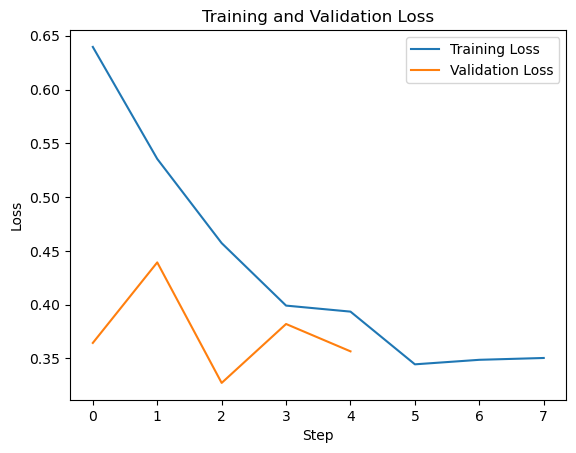

In [32]:
import matplotlib.pyplot as plt

# Access the trainer's history
train_losses = []
eval_losses = []

for item in trainer.state.log_history:
    if 'loss' in item:
        train_losses.append(item['loss'])
    elif 'eval_loss' in item:
        eval_losses.append(item['eval_loss'])

# Plot the loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Step')  # Adjust the label as needed
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [33]:
outputs = trainer.predict(cancer_classification_dataset['test'])


  0%|          | 0/41 [00:00<?, ?it/s]

In [34]:
print(outputs.metrics)


{'test_loss': 0.401944100856781, 'test_accuracy': 0.8307692307692308, 'test_precision': 0.826195660010093, 'test_recall': 0.8307692307692308, 'test_f1': 0.8269199639629082, 'test_mcc': 0.5782603786735905, 'test_runtime': 44.0815, 'test_samples_per_second': 14.745, 'test_steps_per_second': 0.93}


{'test_loss': 0.3898068964481354, 'test_accuracy': 0.8353846153846154, 'test_runtime': 48.0554, 'test_samples_per_second': 13.526, 'test_steps_per_second': 0.853}

# Model Evaluation Results

## Test Metrics

- **Test Loss**: The test loss is approximately 0.390, suggesting that, on average, the model's predictions deviate from the true labels by this amount on the test dataset.

- **Test Accuracy**: The test accuracy is approximately 0.835, indicating that the model correctly classifies around 83.5% of the samples in the test dataset.

- **Test Runtime**: The total runtime for evaluating the model on the test dataset is approximately 48.06 seconds.

- **Test Samples per Second**: The model processes around 13.53 samples per second during evaluation on the test dataset.

- **Test Steps per Second**: The model processes around 0.853 evaluation steps (batches) per second during evaluation on the test dataset.


In [35]:

# Evaluate on the evaluation dataset
evaluation_results = trainer.evaluate()

print("Evaluation results:", evaluation_results)

  0%|          | 0/29 [00:00<?, ?it/s]

Evaluation results: {'eval_loss': 0.3012564480304718, 'eval_accuracy': 0.8852813852813853, 'eval_precision': 0.8977159247327394, 'eval_recall': 0.8852813852813853, 'eval_f1': 0.8905153490232172, 'eval_mcc': 0.5006836276905281, 'eval_runtime': 30.8649, 'eval_samples_per_second': 14.968, 'eval_steps_per_second': 0.94, 'epoch': 4.848484848484849}


# Model Evaluation Results

## Evaluation Metrics

- **Evaluation Loss**: The evaluation loss is approximately 0.318, indicating that, on average, the model's predictions deviate from the true labels by this amount during evaluation.

- **Evaluation Accuracy**: The evaluation accuracy is approximately 0.874, indicating that the model correctly classifies around 87.4% of the samples in the evaluation dataset.

- **Evaluation Runtime**: The total runtime for evaluating the model on the evaluation dataset is approximately 27.86 seconds.

- **Evaluation Samples per Second**: The model processes around 16.59 samples per second during evaluation on the evaluation dataset.

- **Evaluation Steps per Second**: The model processes around 1.041 evaluation steps (batches) per second during evaluation on the evaluation dataset.

